In [1]:
import concurrent.futures
import json
import requests

from datetime import datetime, timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm
from urllib.parse import urlparse, parse_qs

In [2]:
storage = str(Path('~/Downloads').expanduser())

area_code = 'areaCode'
area_name = 'areaName'
area_type = 'areaType'
date = 'date'
new_cases_by_specimen_date = 'newCasesBySpecimenDate'
new_deaths_by_death_date = 'newDeaths28DaysByDeathDate'
new_tests_by_publish_date = 'newTestsByPublishDate'
release_timestamp = 'releaseTimestamp'

ltla = 'ltla'
nation = 'nation'
overview = 'overview'

In [134]:
def get(filters, structure, **params):
    _params={
        'filters':';'.join(f'{k}={v}' for (k, v) in filters.items()),
        'structure': json.dumps({element:element for element in structure}),
    }
    _params.update(params)
    response = requests.get('https://api.coronavirus.data.gov.uk/v1/data', timeout=20, params=_params)
    if response.status_code != 200:
        raise ValueError(f'{response.status_code}:{response.content}')
    return response.json()

In [4]:
def pickle(name, df):
    for_dates = df[release_timestamp].unique()
    assert len(for_dates) == 1, for_dates
    for_date, = for_dates
    path = f'~/Downloads/phe_{name}_{for_date}_{datetime.now():%Y-%m-%d-%H-%M}.pickle'
    df.to_pickle(path)
    return path

In [5]:
def query(filters, structure, max_workers=None, **params):
    page = 1
    response = get(filters, structure, page=page, **params)
    result = response['data']
    max_page = int(parse_qs(urlparse(response['pagination']['last']).query)['page'][0])
    if max_page > 1:
        t = tqdm(total=max_page)
        t.update(1)
        todo = range(2, max_page+1)
        attempt = 0
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers or max_page-1) as executor:
            while todo:
                attempt += 1
                bad = []
                t.set_postfix({'errors': len(bad), 'attempt': attempt})
                futures = {executor.submit(get, filters, structure, page=page, **params): page 
                           for page in todo}
                for future in concurrent.futures.as_completed(futures):
                    page = futures[future]
                    try:
                        response = future.result()
                    except Exception as exc:
                        bad.append(page)
                        t.set_postfix({'errors': len(bad), 'attempt': attempt})
                    else:
                        result.extend(response['data'])
                        t.update(1)
                todo = bad
        t.close()
    return pd.DataFrame(result)

In [164]:
overview_data = query(
    filters={area_type: overview}, 
    structure=[release_timestamp, date, area_name, area_code, 
               new_cases_by_specimen_date, new_deaths_by_death_date, new_tests_by_publish_date]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newDeaths28DaysByDeathDate,newTestsByPublishDate
0,2020-11-16,2020-11-16,United Kingdom,K02000001,NaN,NaN,NaN
1,2020-11-16,2020-11-15,United Kingdom,K02000001,854.0,59.0,284662.0
2,2020-11-16,2020-11-14,United Kingdom,K02000001,13611.0,158.0,344679.0
3,2020-11-16,2020-11-13,United Kingdom,K02000001,22159.0,228.0,385916.0
4,2020-11-16,2020-11-12,United Kingdom,K02000001,23685.0,330.0,383999.0
...,...,...,...,...,...,...,...
314,2020-11-16,2020-01-07,United Kingdom,K02000001,NaN,NaN,NaN
315,2020-11-16,2020-01-06,United Kingdom,K02000001,NaN,NaN,NaN
316,2020-11-16,2020-01-05,United Kingdom,K02000001,NaN,NaN,NaN
317,2020-11-16,2020-01-04,United Kingdom,K02000001,NaN,NaN,NaN


In [165]:
pickle('overview', overview_data)

'~/Downloads/phe_overview_2020-11-16_2020-11-16-20-04.pickle'

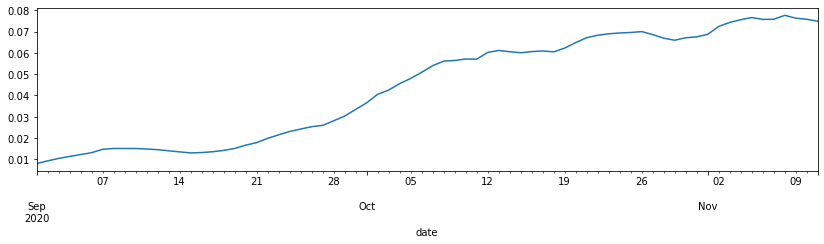

In [166]:
overview_data.index = pd.to_datetime(overview_data[date])
overview_data.sort_index(inplace=True)
smoothed_overview_data = overview_data.rolling(window=7).mean()
cases_per_test = (smoothed_overview_data[new_cases_by_specimen_date] / smoothed_overview_data[new_tests_by_publish_date])
cases_per_test.loc['2020-09-01':datetime.now()-timedelta(days=5)].plot(figsize=(14,3))
plt.gcf().set_facecolor('white')

In [167]:
nation_data = query(
    filters={area_type: nation}, 
    structure=[release_timestamp, date, area_name, area_code, new_cases_by_specimen_date, new_deaths_by_death_date]
)
nation_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newDeaths28DaysByDeathDate
0,2020-11-16,2020-11-16,England,E92000001,NaN,NaN
1,2020-11-16,2020-11-15,England,E92000001,521.0,48.0
2,2020-11-16,2020-11-14,England,E92000001,12163.0,145.0
3,2020-11-16,2020-11-13,England,E92000001,19938.0,205.0
4,2020-11-16,2020-11-12,England,E92000001,21212.0,292.0
...,...,...,...,...,...,...
1271,2020-11-16,2020-01-07,Wales,W92000004,NaN,NaN
1272,2020-11-16,2020-01-06,Wales,W92000004,NaN,NaN
1273,2020-11-16,2020-01-05,Wales,W92000004,NaN,NaN
1274,2020-11-16,2020-01-04,Wales,W92000004,NaN,NaN


In [168]:
pickle('nation', nation_data)

'~/Downloads/phe_nation_2020-11-16_2020-11-16-20-05.pickle'

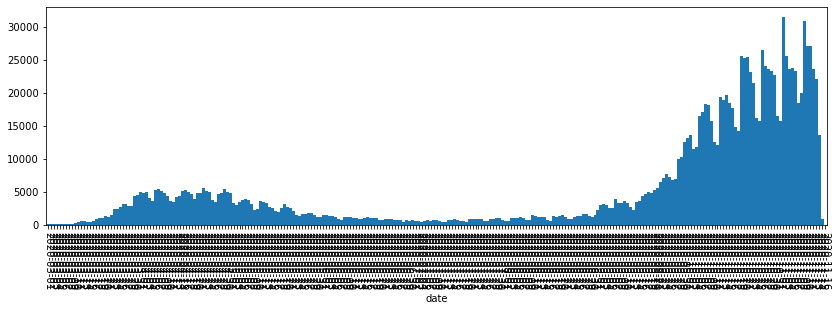

In [169]:
nation_data.groupby(date).sum()[new_cases_by_specimen_date].loc['2020-03-01':].plot(kind='bar', stacked=True, width=1, rot=-90, figsize=(14, 4))

In [170]:
area_data = query(
    filters={area_type: ltla}, 
    structure=[release_timestamp, date, area_name, area_code, new_cases_by_specimen_date, new_deaths_by_death_date],
    max_workers=10
)
area_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newDeaths28DaysByDeathDate
0,2020-11-16,2020-11-16,Aberdeen City,S12000033,NaN,NaN
1,2020-11-16,2020-11-15,Aberdeen City,S12000033,0.0,0.0
2,2020-11-16,2020-11-14,Aberdeen City,S12000033,10.0,0.0
3,2020-11-16,2020-11-13,Aberdeen City,S12000033,23.0,0.0
4,2020-11-16,2020-11-12,Aberdeen City,S12000033,26.0,0.0
...,...,...,...,...,...,...
121534,2020-11-16,2020-09-26,Wychavon,E07000238,6.0,0.0
121535,2020-11-16,2020-09-25,Wychavon,E07000238,4.0,0.0
121536,2020-11-16,2020-09-24,Wychavon,E07000238,6.0,0.0
121537,2020-11-16,2020-09-23,Wychavon,E07000238,2.0,1.0


In [171]:
pickle('area', area_data)

'~/Downloads/phe_area_2020-11-16_2020-11-16-20-05.pickle'